In [1]:
%%bash
fasta_file=test.fa
folder=/staging/leuven/stg_00002/lcb/hsnyers/Github/torch_scBasset/results
cd ${folder}

module load Cluster-Buster/20220421-GCCcore-6.4.0
while read -r line
do
matrix_file=/staging/leuven/stg_00002/lcb/icistarget/data/motifCollection/v9/singletons/${line}.cb
cbust -c 0 -m 0 -f 5 ${matrix_file} ${fasta_file} > ${fasta_file%.fa}.${line}.bed
done < selected_motifs.txt
cat ${fasta_file%.fa}.*.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 > ${fasta_file%.fa}.selected.motif.gff

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def gff_to_npz(filename):
    with open(filename) as file:
        seq_names = []
        main_dict = {}
        for line in file:
            if line.startswith("#"):
                continue
            tabs = line.strip().split('\t')
            seq_name = tabs[0]
            start = int(tabs[1])
            end = int(tabs[2])
            motif_name = tabs[3]
            score = float(tabs[4])
            strand = tabs[5]

            if seq_name not in main_dict:
                main_dict[seq_name]={}
                seq_names.append(seq_name)
            if motif_name not in main_dict[seq_name]:
                main_dict[seq_name][motif_name] = []
            main_dict[seq_name][motif_name].append([start,end,score,strand]) 
    return seq_names,main_dict

def plot_cbust_with_logo(plotting_id,threshold=3,st=0,end=500, plot_logos=False, ymin=-10, ymax=10):
    fig = plt.figure(figsize=(40,3))
    if plotting_id in cbust_mot_dict:
        single_m = cbust_mot_dict[plotting_id]
        ax = fig.add_subplot(1,1,1)
        ax.set_title(plotting_id)
        ax.plot(np.zeros(end-st), color = 'gray')
        for motif in [xx for xx in all_motifs_dict if xx in list(single_m.keys())]: 
            color = all_motifs_dict[motif][0]           
            for single_motif in single_m[motif]:
                if single_motif[2] >= threshold:
                    if single_motif[3]=='-':
                        ax.add_patch(matplotlib.patches.Rectangle(xy=[single_motif[0]-st,-1*single_motif[2]] ,
                                                         width=single_motif[1]-single_motif[0] ,
                                                         height=single_motif[2],
                                                         color=color, fill=False, linewidth=3))
                    else:
                        ax.add_patch(matplotlib.patches.Rectangle(xy=[single_motif[0]-st,0] ,
                                                         width=single_motif[1]-single_motif[0] ,
                                                         height=single_motif[2],
                                                         color=color, fill=False, linewidth=3))    
        _ = ax.set_xticks(np.arange(0, end-st+1, 10))
        ax.axis([0,end-st+1,ymin,ymax])
    else:
        ax = fig.add_subplot(1,1,1)
        ax.plot(np.zeros(end-st), color = 'gray')
        _ = ax.set_xticks(np.arange(0, end-st+1, 10))
        ax.axis([0,end-st+1,ymin,ymax])

    if plot_logos:
        number_of_motifs = len(all_motifs_dict)
        fig = figure(figsize=(5*number_of_motifs,4))
        for k,name in enumerate(all_motifs_dict):
            url = "http://motifcollections.aertslab.org/v9/logos/" + name + ".png"
            a=fig.add_subplot(1,number_of_motifs,k+1)   
            image = imread(url)
            imshow(image,cmap='Greys_r')
            #a.set_title(selected_mot_col[k],color=selected_mot_col[k].split('-')[0],fontweight="bold")
            a.spines['top'].set_visible(False)
            a.spines['right'].set_visible(False)
            a.spines['bottom'].set_visible(False)
            a.spines['left'].set_visible(False)
            a.get_yaxis().set_ticks([])
            a.get_yaxis().set_ticks([])
            a.set_yticklabels([])
            a.set_xticklabels([])
            a.set_xlabel(name,color=all_motifs_dict[name][0],fontweight="bold")

In [5]:
gff_filename = '/staging/leuven/stg_00002/lcb/hsnyers/Github/torch_scBasset/results/test.selected.motif.gff'
selected_motifs_filename = "/staging/leuven/stg_00002/lcb/hsnyers/Github/torch_scBasset/results/selected_motifs.txt"

COLOR = [ 
    "#004D43", "#4FC601", "#809693", "#008941", "#FF4A46", "#A30059",
    "#7A4900", "#B79762", "#0000A6", "#8FB0FF", "#FF34FF", "#997D87",
    "#5A0007", "#1CE6FF", "#000000", "#006FA6", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",]

seq_names, cbust_mot_dict = gff_to_npz(gff_filename) 
all_motifs_dict = {}
with open(selected_motifs_filename,'r') as rmot:
    counter=0
    for line in rmot:
        print(line)
        all_motifs_dict[line.strip().split('\t')[0].rstrip('.cb')] = [COLOR[counter]]
        print(all)
        counter+=1

jaspar__MA0139.1



In [4]:
all_motifs_dict

{'jaspar__MA0139.1': ['#004D43']}

In [68]:
cbust_mot_dict

{'chr17:69098581-69099081': {'jaspar__MA0139.1': [[714, 733, 4.3, '-'],
   [343, 362, 3.84, '+']]},
 'chr3:43708998-43709498': {'jaspar__MA0139.1': [[167, 186, 6.87, '-']]},
 'chr3:100708207-100708707': {'jaspar__MA0139.1': [[606, 625, 3.8, '-'],
   [609, 628, 5.15, '-'],
   [731, 750, 4.37, '-'],
   [257, 276, 2.5, '-'],
   [259, 278, 3.38, '+']]},
 'chr11:34242783-34243283': {'jaspar__MA0139.1': [[413, 432, 5.0, '+'],
   [197, 216, 3.45, '+']]}}

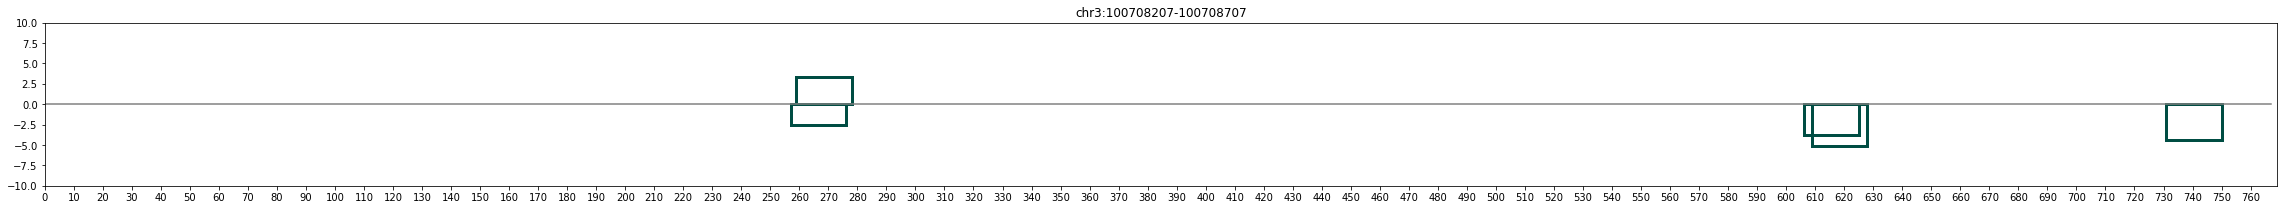

In [66]:
plot_cbust_with_logo(plotting_id = "chr3:100708207-100708707", threshold=0, st=0, end=768, plot_logos=False ,ymin=-10, ymax=10)

/local_scratch/tmp-vsc34619/ipykernel_9893/3048297821.py:68: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  image = imread(url)


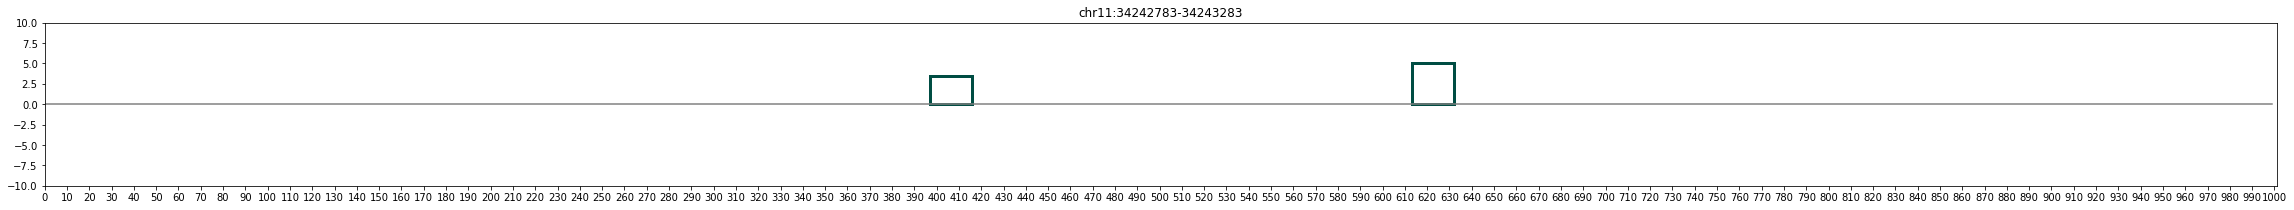

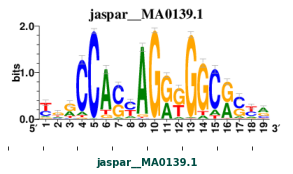

In [63]:
plot_cbust_with_logo(plotting_id = "chr11:34242783-34243283", threshold=0, st=-200, end=800, plot_logos=True ,ymin=-10, ymax=10)